<a href="https://colab.research.google.com/github/martinfernandoortiz/wordCloud_Geografia/blob/main/wordCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Word Cloud - IV Congreso Nacional de Geografía de Universidades Públicas

Se generó una nueve de palabras a partir de la última circular del Congreso Nacional de Geografía de Universidades Públicas. El trabajo se divide en los siguientes pasos:
- pasar el pdf a texto
- limpiar el texto con las palabras que no queremos (pronombres, nombres propios, apellidos)
- generación de imagen


## **Pasar** el pdf a texto

In [2]:
pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.3 MB/s eta 0:00:00


In [3]:
# importing required modules
from PyPDF2 import PdfReader
from PIL import Image
from io import BytesIO
from wordcloud import WordCloud
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import zipfile
import plotly.express as px
import plotly.graph_objects as go
import colorsys
from matplotlib.cm import viridis
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
reader = PdfReader('/content/drive/MyDrive/datasets_colab/congresoPROGRAMA.pdf')

In [5]:
# printing number of pages in pdf file
print(len(reader.pages))
largo = len(reader.pages)
text = ""

43


In [6]:
#loopeamos la cantidad de paginas del pdf
for x in range(0, largo):
# getting a specific page from the pdf file
  page = reader.pages[x]
# extracting text from page
  text = text + page.extract_text()


## Generación de la nube de palabras sin filtrar

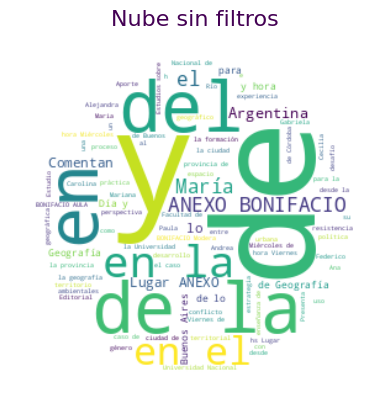

In [45]:
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

# Agrega un título al gráfico
plt.title("Nube sin filtros", fontsize=16, color="#440154")

# Guarda la figura antes de mostrarla
plt.savefig('/content/drive/MyDrive/datasets_colab/imagenes/crudo.jpg', bbox_inches='tight', dpi=75)

# Muestra la figura después de guardarla
plt.show()

## Limpieza del texto


Se crea un dataframe de una columna para poder ver más facil los patrones de texto que hay que eliminar. El dataframe lo grabamos como tabla y de ahi voy a copiar grandes patrones de texto que no nos interesan.

In [8]:
import pandas as pd
lines = text.splitlines()

# Crear un DataFrame con una columna llamada 'texto'
df = pd.DataFrame({'texto': lines})

# Quitar espacios en blanco al principio y al final de cada registro
#df['texto'] = df['texto'].str.strip()

# Ordenar el DataFrame alfabéticamente por la columna 'texto'
df = df.sort_values(by='texto')

# Mostrar el DataFrame
#print(df)

# Guardar el DataFrame en un archivo Excel
df.to_excel('/content/drive/MyDrive/datasets_colab/output.xlsx', index=False)


Se genero un texto que va a tener los patrones a reemplazar. Esto se hizo de forma manual y se puede ver en el archivo quitar.txt
Con este vamos a hacer un replace

In [9]:
#text = "..."  # Reemplaza "..." con tu cadena de texto
#quitar_filename = 'quitar.txt'

with open('/content/drive/MyDrive/datasets_colab/quitar.txt', 'r') as file:
    lines_to_remove = file.readlines()


# Elimina los espacios en blanco al principio y al final de cada línea y convierte a conjunto para manejar duplicados
lines_to_remove = set(line.strip() for line in lines_to_remove)

# Aplica el reemplazo en 'text' para cada línea en 'lines_to_remove'
for line_to_remove in lines_to_remove:
    text = text.replace(line_to_remove.strip(), '')

# Muestra el resultado
#print(text)

# Si deseas guardar el resultado en un nuevo archivo 'text_filtered.txt'
with open('text_filtered.txt', 'w') as file:
    file.write(text)

## Filtro de palabras no deseadas

- Vamos a generar una variable llamada stopwords para eliminar pronombres y palabras que no hacen al análisis
- Vamos a utilizar un dataset con los nombres más frecuentes de argentina para borrar los nombres de los autores de la nube.
- Vamos a filtrar los apellidos con un dataset de apellidos por provincia

In [10]:
stopwords_total = ["de", "Día", "hora", "lo", "Anexo", "Bonifacio", "del", "en", "la", "el", "Universidad", "Nacional",
                            "las","para","a","Comentan","Moderan","entre","Facultad","Jueves","Miércoles","los","Mesa","Aula","I","II","como","estrategia","su","Instituto",
                            "e","al","y","una","desde","un","María","h","con","sobre","hs","Modera","Presenta","por","café"]

Vamos a quitar nombres a partir de un archivo de nombres más frecuentes en Argentina

In [11]:
# URL del archivo ZIP
url = "https://infra.datos.gob.ar/catalog/otros/dataset/2/distribution/2.1/download/historico-nombres.zip"

# Descargar y descomprimir el archivo ZIP
response = requests.get(url)
with zipfile.ZipFile(BytesIO(response.content), 'r') as zip_ref:
    zip_ref.extractall()

# Listar los archivos descomprimidos (para verificar el nombre del archivo CSV)
file_names = zip_ref.namelist()

# Elegir el nombre del archivo CSV (puede variar)
csv_file_name = [name for name in file_names if name.endswith('.csv')][0]

# Cargar el archivo CSV con pandas
df = pd.read_csv(csv_file_name)

In [12]:
# Limpiar la columna 'nombre' (extraer la primera palabra)
df['nombre'] = df['nombre'].apply(lambda x: re.split(r'\s+', str(x))[0])

# Obtener una lista de nombres únicos
unique_names = df['nombre'].drop_duplicates().tolist()

# Mostrar la lista de nombres únicos
#print(unique_names)

Generamos un listado de stopwords con los que había antes y los nombres

In [13]:
#Generamos un listado con las palabras que no suman y los nombres
stopwords_total.extend(unique_names)

In [18]:
import ssl

# Desactiva la verificación del certificado SSL
ssl._create_default_https_context = ssl._create_unverified_context

# URL del archivo CSV
url = 'https://datosabiertos.renaper.gob.ar/apellidos_cantidad_personas_provincia.csv'

# Lee el archivo CSV desde la URL
df = pd.read_csv(url)
# URL del archivo CSV

#solo primer letra en mayuscula
apellido = df["apellido"].drop_duplicates(keep='first').str.capitalize().tolist()





In [28]:
#Generamos un listado con las palabras que no suman y los nombres
stopwords_total.extend(apellido)

## Nube de palabras (con stopwords)

Se agregan algunas stopwords

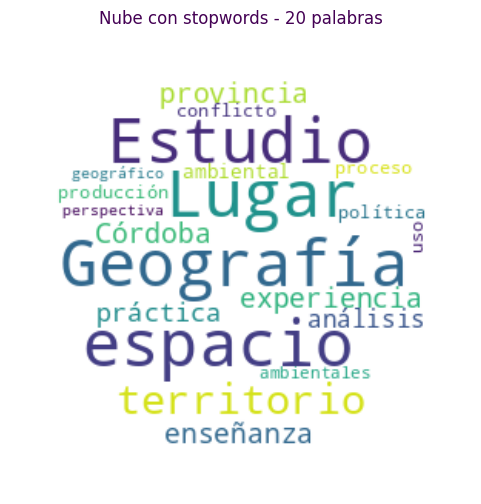

In [47]:
#Forma de Circulo
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)


wc = WordCloud(height = 300, width = 300, background_color="white", repeat=True,
               mask=mask,
               max_font_size = 42, min_font_size = 6,
               #colormap = "magma",
               max_words = 20,
               #contour_width = .1, contour_color = "grey",
               stopwords = stopwords_total)
wc.generate(text)


plt.figure(figsize=(6, 6))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

plt.title("Nube con stopwords - 20 palabras", fontsize=12, color="#440154")

# Guarda la figura antes de mostrarla
plt.savefig('/content/drive/MyDrive/datasets_colab/imagenes/circulo20.jpg', bbox_inches='tight', dpi=75)

# Muestra la figura después de guardarla
plt.show()

## Nube de Palabras Filtrada - Argentina

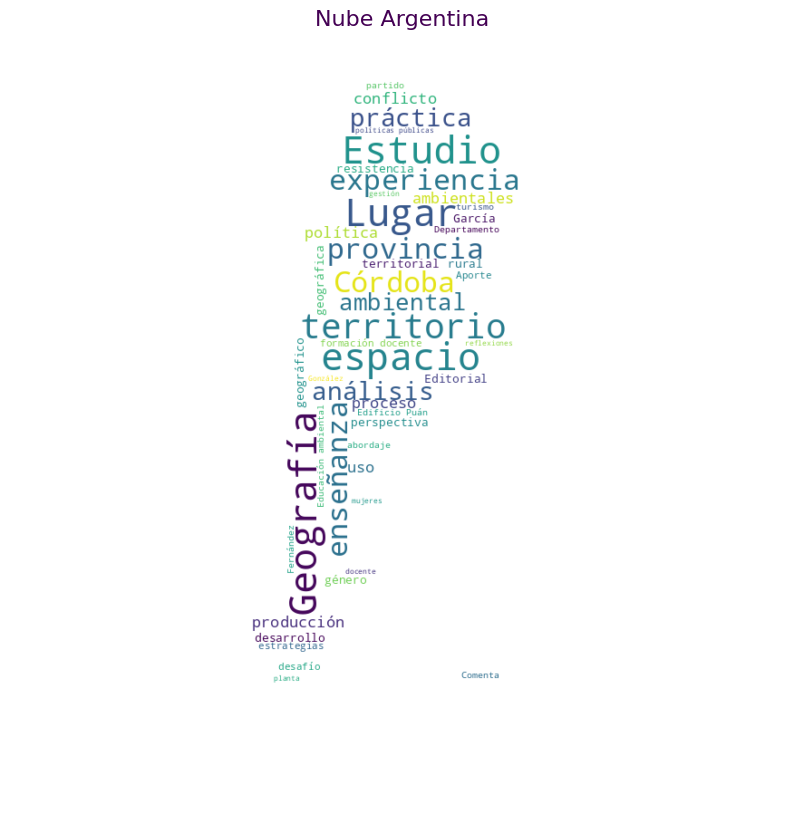

In [48]:
#Forma Imagen
mask = np.array(Image.open("/content/drive/MyDrive/datasets_colab/argentina.jpg"))

wc = WordCloud(height = 300, width = 300, background_color="white", repeat=True,
               mask=mask,
               max_font_size = 42, min_font_size = 6,
               #colormap = "magma",
               #max_words = 3,
               #contour_width = .1, contour_color = "grey",
               stopwords = stopwords_total)
wc.generate(text)


plt.figure(figsize=(20, 10))


plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

plt.title("Nube Argentina", fontsize=16, color="#440154")

# Guarda la figura antes de mostrarla
plt.savefig('/content/drive/MyDrive/datasets_colab/imagenes/argentina.jpg', bbox_inches='tight', dpi=75)

# Muestra la figura después de guardarla
plt.show()

## Nube de Palabras Filtrada - Argentina Dark

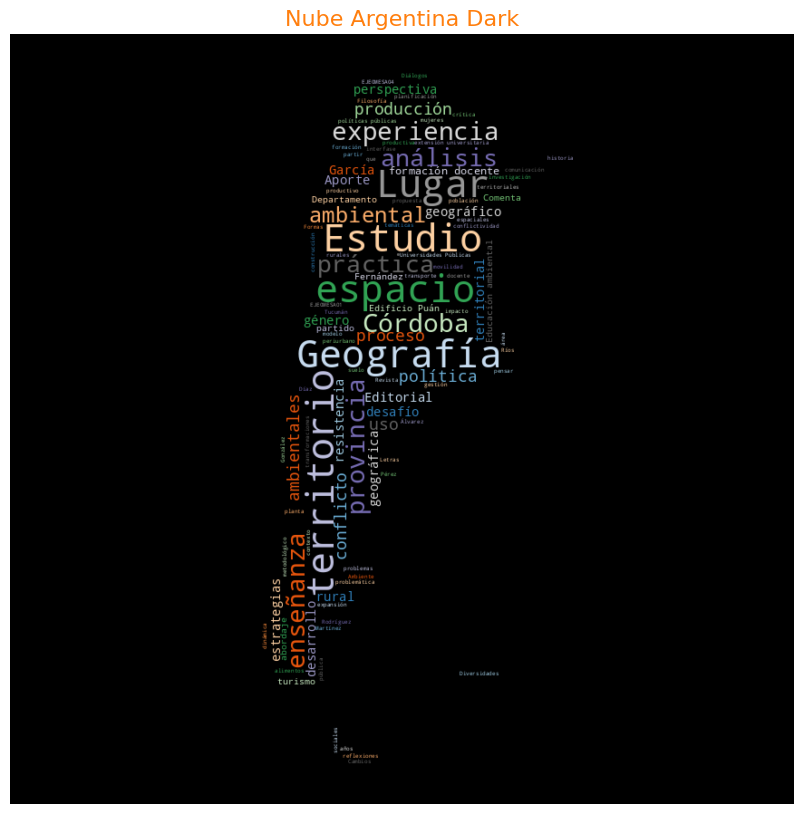

In [49]:
mask = np.array(Image.open("/content/drive/MyDrive/datasets_colab/argentina.jpg"))

wc = WordCloud(height=300, width=300, background_color="black", repeat=True,
               mask=mask,
               max_font_size=42, min_font_size=6,
               colormap="tab20c",
               stopwords=stopwords_total)
wc.generate(text)

plt.figure(figsize=(20, 10))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

plt.title("Nube Argentina Dark", fontsize=16, color="#ff7f0e")

# Guarda la figura antes de mostrarla
plt.savefig('/content/drive/MyDrive/datasets_colab/imagenes/wordArgDark1.jpg', bbox_inches='tight', dpi=75)

# Muestra la figura después de guardarla
plt.show()

## Nube de palabras dark

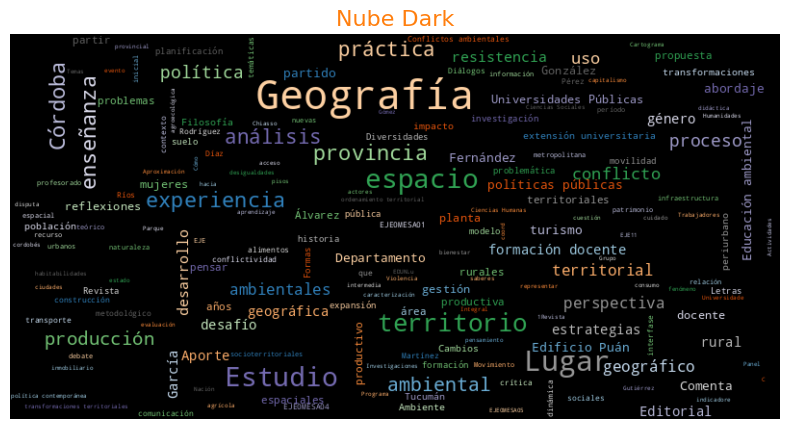

In [50]:
wordcloud = WordCloud(width=800, height=400, relative_scaling=0.5,
                      background_color="black",
               max_font_size = 42, min_font_size = 6,
               colormap = "tab20c",
               #max_words = 3,
               #contour_width = .1, contour_color = "grey",
               stopwords = stopwords_total).generate(text)

# Muestra la WordCloud con matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.title("Nube Dark", fontsize=16, color="#ff7f0e")

# Guarda la figura antes de mostrarla
plt.savefig('/content/drive/MyDrive/datasets_colab/imagenes/wordDark.jpg', bbox_inches='tight', dpi=75)

# Muestra la figura después de guardarla
plt.show()


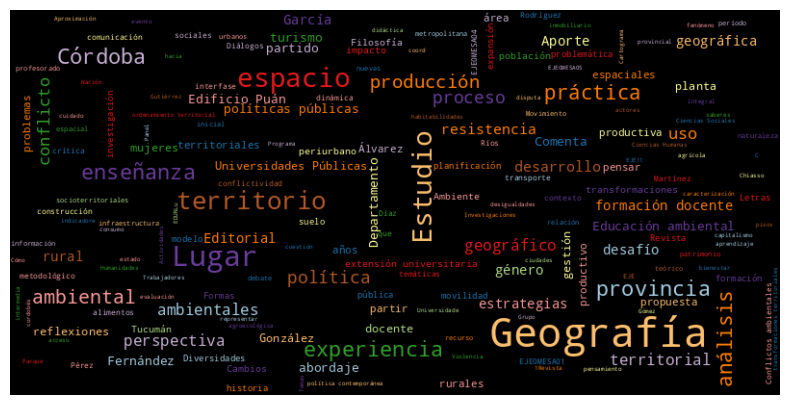

In [38]:
wordcloud = WordCloud(width=800, height=400, relative_scaling=0.5,
                      background_color="black",
               max_font_size = 42, min_font_size = 6,
               #colormap = "rainbow",
               #colormap = "Set2",
              colormap = "Paired",


               #max_words = 20,
               #contour_width = .1, contour_color = "grey",
               stopwords = stopwords_total).generate(text)

# Muestra la WordCloud con matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<ipython-input-52-916eb4968668>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_top_30['Word'], rotation=90, ha='center', color='#fb9a99')


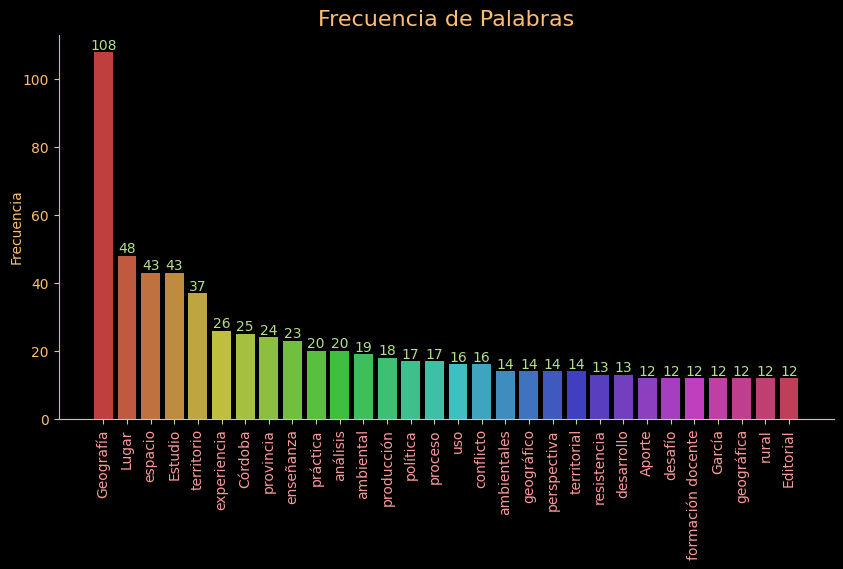

In [52]:

# Configura la WordCloud con el tamaño deseado y fondo oscuro
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Paired', stopwords=stopwords_total)

# Genera las frecuencias de palabras
word_frequencies = wordcloud.process_text(text)

# Crea un DataFrame con las frecuencias de palabras
df_word_frequencies = pd.DataFrame(list(word_frequencies.items()), columns=['Word', 'Frecuencia'])

# Ordena el DataFrame de forma descendente por frecuencia
df_word_frequencies = df_word_frequencies.sort_values(by='Frecuencia', ascending=False)

# Toma solo las 30 palabras más repetidas
df_top_30 = df_word_frequencies.head(30)

# Obtén colores de la WordCloud utilizando el modelo de color HSL
hsl_colors = [(i / len(df_top_30), 0.5, 0.5) for i in range(len(df_top_30))]

# Convierte colores HSL a RGB
rgb_colors = [colorsys.hls_to_rgb(h, l, s) for (h, l, s) in hsl_colors]

# Convierte valores RGB a formato hexadecimal
hex_colors = ['#%02x%02x%02x' % (int(r * 255), int(g * 255), int(b * 255)) for (r, g, b) in rgb_colors]

# Crea un gráfico de barras con Matplotlib
fig, ax = plt.subplots(figsize=(10, 5), facecolor='black')  # Fondo negro de la figura
bars = ax.bar(df_top_30['Word'], df_top_30['Frecuencia'], color=hex_colors)

# Agrega etiquetas con el número en cada barra sin decimales
for bar, label in zip(bars, df_top_30['Frecuencia']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(label)}', ha='center', va='bottom', color='#b2df8a')

# Ajusta el fondo y el color del texto y etiquetas
ax.set_facecolor('black')
ax.tick_params(axis='x', colors='#b2df8a')
ax.tick_params(axis='y', colors='#fdbf6f')
ax.spines['bottom'].set_color('#a6cee3')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('#cab2d6')

# Etiquetas del eje x rotadas -90 grados
ax.set_xticklabels(df_top_30['Word'], rotation=90, ha='center', color='#fb9a99')

# Etiqueta del eje y rotada 90 grados
ax.set_ylabel('Frecuencia', rotation=90, va='center', color='#fdbf6f')

plt.title("Frecuencia de Palabras", fontsize=16, color="#fdbf6f")

# Guarda la figura antes de mostrarla
plt.savefig('/content/drive/MyDrive/datasets_colab/imagenes/barras.jpg', bbox_inches='tight', dpi=75)

# Muestra la figura después de guardarla
plt.show()

<ipython-input-53-d3a7e85ce21f>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_top_30['Word'], rotation=90, ha='center', color='#fdbf6f')


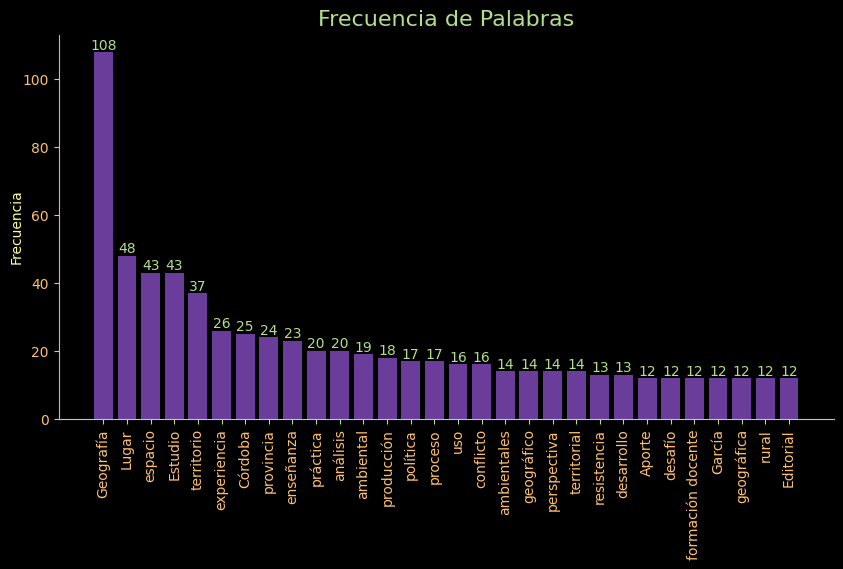

In [53]:

# Configura la WordCloud con el tamaño deseado y fondo oscuro
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Paired', stopwords=stopwords_total)

# Genera las frecuencias de palabras
word_frequencies = wordcloud.process_text(text)

# Crea un DataFrame con las frecuencias de palabras
df_word_frequencies = pd.DataFrame(list(word_frequencies.items()), columns=['Word', 'Frecuencia'])

# Ordena el DataFrame de forma descendente por frecuencia
df_word_frequencies = df_word_frequencies.sort_values(by='Frecuencia', ascending=False)

# Toma solo las 30 palabras más repetidas
df_top_30 = df_word_frequencies.head(30)

# Configura un color específico para todas las barras
bar_color = '#6a3d9a'

# Crea un gráfico de barras con Matplotlib
fig, ax = plt.subplots(figsize=(10, 5), facecolor='black')  # Fondo negro de la figura
bars = ax.bar(df_top_30['Word'], df_top_30['Frecuencia'], color=bar_color)

# Agrega etiquetas con el número en cada barra sin decimales
for bar, label in zip(bars, df_top_30['Frecuencia']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(label)}', ha='center', va='bottom', color='#b2df8a')

# Ajusta el fondo y el color del texto y etiquetas
ax.set_facecolor('black')
ax.tick_params(axis='x', colors='#b2df8a')
ax.tick_params(axis='y', colors='#fdbf6f')
ax.spines['bottom'].set_color('#a6cee3')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('#cab2d6')

# Etiquetas del eje x rotadas -90 grados
ax.set_xticklabels(df_top_30['Word'], rotation=90, ha='center', color='#fdbf6f')

# Etiqueta del eje y rotada 90 grados
ax.set_ylabel('Frecuencia', rotation=90, va='center', color='#ffff99')

plt.title("Frecuencia de Palabras", fontsize=16, color="#b2df8a")


# Muestra el gráfico
plt.show()